In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.datasets

In [5]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [6]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [7]:
len(y_train), len(y_test)

(60000, 10000)

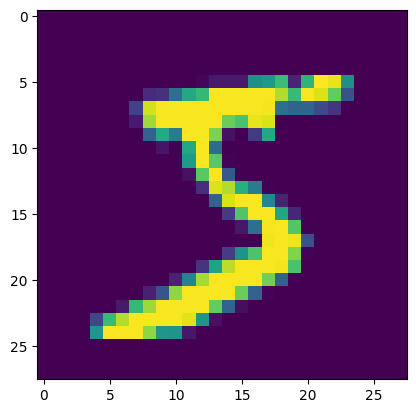

tensor(5)


In [8]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [10]:
X_train.shape # 1 - число изображеий, 2 - число каналов, глбуина, 3, 4 - размерность

torch.Size([60000, 1, 28, 28])

In [11]:
class LeNetChanged(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=32, out_channels=128, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(
            in_channels=128, out_channels=64, kernel_size=3, padding=2)
        self.act3  = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(3 * 3 * 64, 120)
        self.act4  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act5  = torch.nn.Sigmoid()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)

        return x

lenet5 = LeNetChanged()

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-4)

In [14]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(500):
    # собираем среднее значение лосса для батчей на эпохе
    all_losses_batch = []
    all_accuracies_batch = []

    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        all_losses_batch.append(loss_value.data.cpu())
        all_accuracies_batch.append((preds.argmax(dim=1) == y_batch).float().mean().data.cpu())

        optimizer.step()

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    # регистрируем данные по трейну
    train_loss_history.append(sum(all_losses_batch)/len(all_losses_batch))
    accuracy_train = sum(all_accuracies_batch)/len(all_accuracies_batch)
    train_accuracy_history.append(accuracy_train)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print('epoch', epoch, 'accuracy', accuracy)

epoch 0 accuracy tensor(0.9763)
epoch 1 accuracy tensor(0.9858)
epoch 2 accuracy tensor(0.9868)
epoch 3 accuracy tensor(0.9925)
epoch 4 accuracy tensor(0.9919)
epoch 5 accuracy tensor(0.9927)
epoch 6 accuracy tensor(0.9917)
epoch 7 accuracy tensor(0.9932)
epoch 8 accuracy tensor(0.9929)
epoch 9 accuracy tensor(0.9933)
epoch 10 accuracy tensor(0.9924)
epoch 11 accuracy tensor(0.9926)
epoch 12 accuracy tensor(0.9939)
epoch 13 accuracy tensor(0.9931)
epoch 14 accuracy tensor(0.9939)
epoch 15 accuracy tensor(0.9933)
epoch 16 accuracy tensor(0.9925)
epoch 17 accuracy tensor(0.9925)
epoch 18 accuracy tensor(0.9942)
epoch 19 accuracy tensor(0.9931)
epoch 20 accuracy tensor(0.9943)
epoch 21 accuracy tensor(0.9936)
epoch 22 accuracy tensor(0.9929)
epoch 23 accuracy tensor(0.9927)
epoch 24 accuracy tensor(0.9938)
epoch 25 accuracy tensor(0.9943)
epoch 26 accuracy tensor(0.9942)
epoch 27 accuracy tensor(0.9941)
epoch 28 accuracy tensor(0.9945)
epoch 29 accuracy tensor(0.9935)
epoch 30 accuracy te

KeyboardInterrupt: ignored

In [19]:
lenet5.forward(X_test)

tensor([[-4.1524, -3.3099, -3.1822,  ...,  8.7568, -3.6758, -2.4739],
        [-3.3176, -3.7034,  8.9762,  ..., -3.1541, -3.6893, -4.7198],
        [-3.4817,  9.7435, -2.9292,  ..., -2.2267, -2.0271, -2.5175],
        ...,
        [-4.6937, -5.0786, -3.3477,  ..., -3.1336, -2.3833, -1.4900],
        [-3.1728, -3.6293, -5.3910,  ..., -4.7982, -2.9174, -3.3443],
        [-2.5018, -4.3054, -5.3277,  ..., -2.9779, -2.3148, -4.2276]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

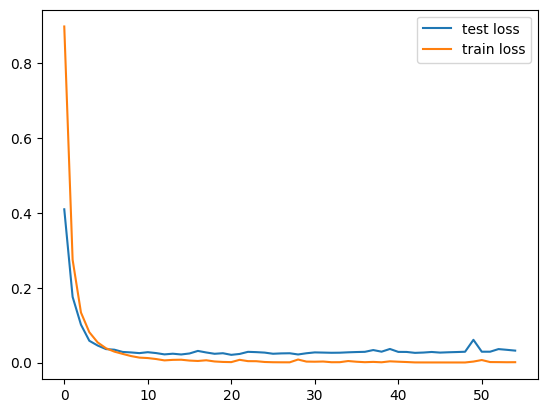

In [20]:
plt.plot(test_loss_history, label='test loss')
plt.plot(train_loss_history, label='train loss')
plt.legend()

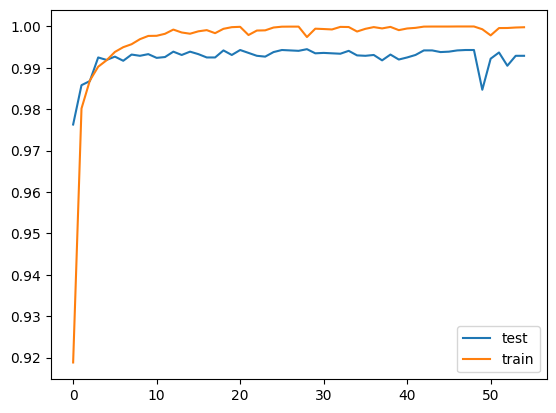

In [21]:
plt.plot(test_accuracy_history, label='test')
plt.plot(train_accuracy_history, label = 'train')
plt.legend()

In [22]:
max(test_accuracy_history)

tensor(0.9945)